In [2]:
#This file is only looking at the roster plots for old organoid data
import networkx as nx
import numpy as np
import pickle
import pandas as pd
from scipy.io import loadmat
import h5py
from scipy.ndimage import gaussian_filter
from scipy.signal import correlate, gaussian
from scipy.ndimage import gaussian_filter1d
from tqdm import tqdm
import itertools
from pathlib import Path
import torch
from torch.nn import functional as F
from matplotlib import pyplot as plt

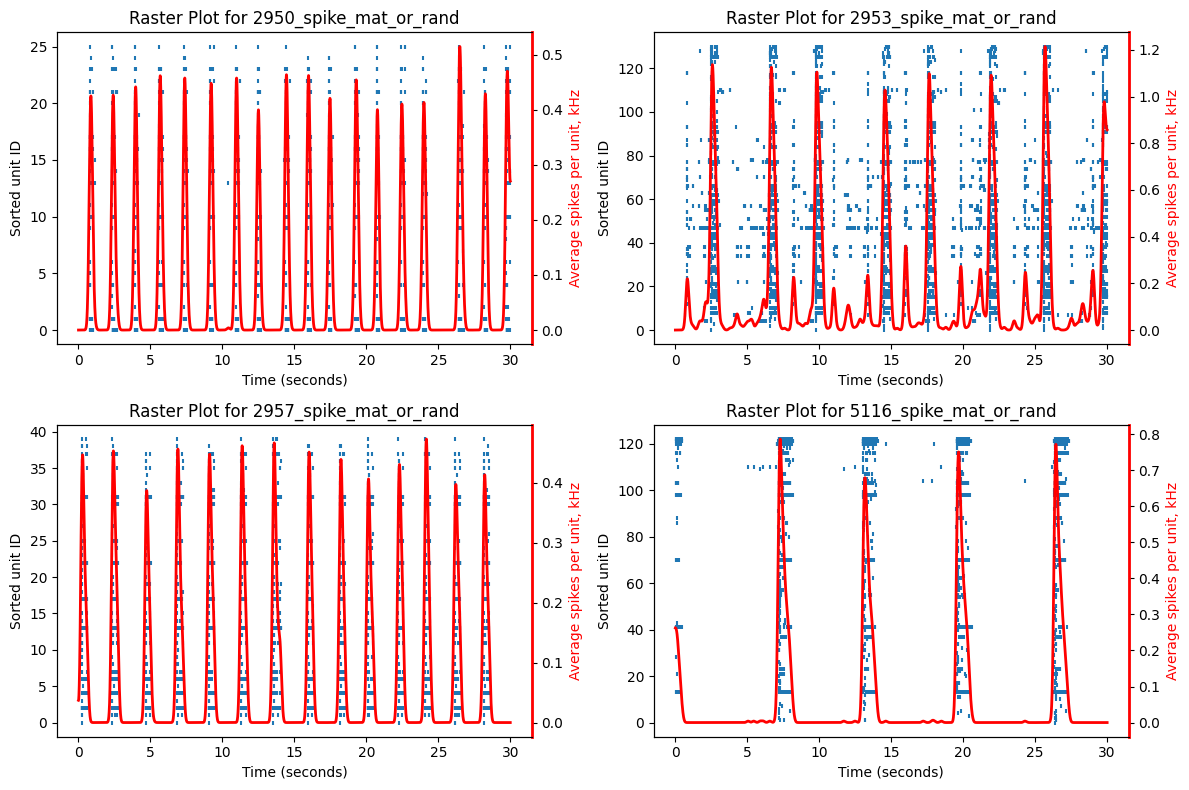

In [38]:
ALL_FILES = [
    "2950_spike_mat_or_rand", #26
    "2953_spike_mat_or_rand", #Tal paper
    "2957_spike_mat_or_rand",
    "5116_spike_mat_or_rand",
]
# Load your .mat file

"""
# Raster plots for 3 min of recording

# Parameters:
# - spike_times: 2D array-like, where each row represents a time unit and each column a neuron.
# - units: int, total number of time units.
# - unit_duration_ms: int, duration of each time unit in milliseconds.
# - total_minutes: int, total time span in minutes.
# """

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for idx, fn in enumerate(ALL_FILES):
    data = loadmat(f"{fn}.mat")

    # Extracting all variables from the .mat file
    t_spk_mat = data['t_spk_mat']
    t_spk_mat_rand = data['t_spk_mat_rand']

    # Creating DataFrames for each variable
    df_t_spk_mat = pd.DataFrame(t_spk_mat)
    df_t_spk_mat_rand = pd.DataFrame(t_spk_mat_rand)

    # Plotting the raster plot and average spikes per unit
    ax = axs[idx // 2, idx % 2]
    spike_indices = t_spk_mat[:30*1000].nonzero()
    ax.scatter(spike_indices[0] / 1000.0, spike_indices[1], marker='|', s=10)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Sorted unit ID')
    ax.set_title(f"Raster Plot for {fn}")

    avg_spikes = np.sum(t_spk_mat, axis=1)[:30*1000]
    avg_spikes = avg_spikes.astype(float)
    avg_spikes_smooth = gaussian_filter1d(avg_spikes, 100)

    ax2 = ax.twinx()
    xs = np.linspace(0, len(avg_spikes), len(avg_spikes)) / 1000.0
    ax2.plot(xs, avg_spikes_smooth, color='red', linewidth=2)
    ax2.yaxis.label.set_color('red')
    ax2.set_ylabel('Average spikes per unit, kHz')
    ax2.spines['right'].set_color('red')
    ax2.spines['right'].set_linewidth(2)

plt.tight_layout()
plt.show()


   



The code right below illustrates how to plot instantenous firing rates, i.e. when we pick a specific row in t_spk_mat array and see how this neuron behaves over time (blue), and then Gaussian smooth it with 100 ms window (red)
We call "instantaneous firing rate" the y axis of the Gaussian smoothed signal, since it illustrates the activity at that instant moment, and "firing rate" is the neural activity across the whole time period (for example, 30 sec in this case) - how neuron was firing over that time period

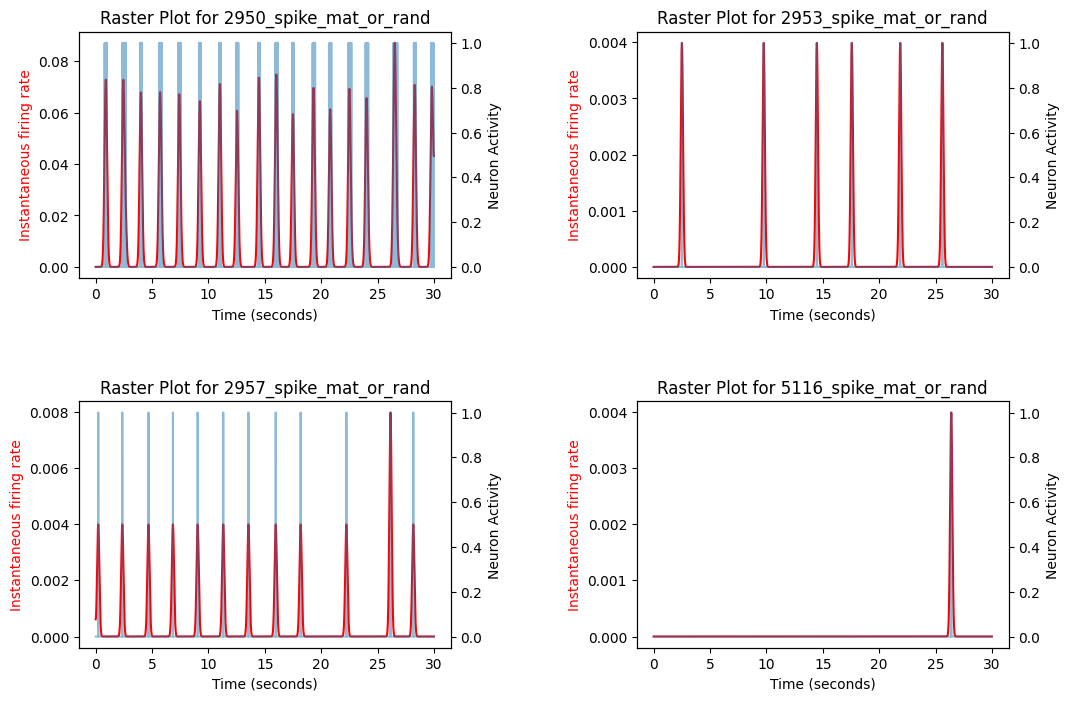

In [133]:
ALL_FILES = [
    "2950_spike_mat_or_rand", #26
    "2953_spike_mat_or_rand", #Tal paper
    "2957_spike_mat_or_rand",
    "5116_spike_mat_or_rand",
]
# Load your .mat file


fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for idx, fn in enumerate(ALL_FILES):
    data = loadmat(f"{fn}.mat")

    # Extracting all variables from the .mat file
    t_spk_mat = data['t_spk_mat']
    neuron = t_spk_mat[:, 0].astype(np.float32)
    xs = np.linspace(0, len(spike_indices), len(spike_indices)) / 1000.0
    spike_indices = neuron[:30*1000]
    spike_indices_gaussian = gaussian_filter1d(spike_indices, 100)


    ax = axs[idx // 2, idx % 2]
    ax.plot(xs, spike_indices_gaussian, label='Gaussian', color='red')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Instantaneous firing rate', color='red')
    ax.set_title(f"Raster Plot for {fn}")
    ax2 = ax.twinx()
    ax2.plot(xs, spike_indices, label='Original', alpha=0.5)
    ax2.set_ylabel('Neuron Activity')
    
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()


    
    
  
    # plt.plot(xs, spike_indices)
    #.nonzero()
    # print(spike_indices)
    # plt.scatter(spike_indices[0] / 1000.0, spike_indices[1], marker='|', s=10)
    # plt.set_xlabel('Time (seconds)')
    # ax.set_ylabel('Sorted unit ID')
    # ax.set_title(f"Raster Plot for {fn}")
   
        

    
    

 



   

